In [1]:
#@title Colab setup: GPU check + installs + imports
!nvidia-smi -L || echo "No GPU detected (CPU-only runtime)."

# OpenCV + tqdm (PyTorch is usually preinstalled in Colab)
!pip install -q opencv-python tqdm

import os
import random
import hashlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


DATA_ZIP_URL = "https://datasets-cvlab.epfl.ch/2019-road-anomaly/RoadAnomaly_jpg.zip"
ZIP_NAME = "RoadAnomaly_jpg.zip"

if not os.path.exists(ZIP_NAME):
    !wget -q "{DATA_ZIP_URL}" -O "{ZIP_NAME}"
    print("Downloaded:", ZIP_NAME)
else:
    print("Zip file already exists, skipping download.")

!unzip -q -o "{ZIP_NAME}" -d .


# Dataset root (folder name after you upload/unzip RoadAnomaly_jpg)
DATASET_ROOT = "/content/RoadAnomaly_jpg"

# If you upload a zip named RoadAnomaly_jpg.zip, auto-unzip it
zip_path = "/content/RoadAnomaly_jpg.zip"
if (not os.path.isdir(DATASET_ROOT)) and os.path.isfile(zip_path):
    import zipfile
    print(f"Found {zip_path}, extracting to /content ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall("/content")
    print("✅ Extraction done.")

@dataclass
class Config:
    dataset_root: str = DATASET_ROOT
    image_size: int = 512
    train_fraction: float = 0.8
    batch_size: int = 4
    num_workers: int = 2
    num_epochs: int = 5          # bump this later if you want
    lr: float = 1e-4
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()
print(cfg)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)
print(f"Using device: {cfg.device}")


GPU 0: Tesla T4 (UUID: GPU-fb51e6b3-3f37-3188-2011-cdf1ab97a3d1)
Downloaded: RoadAnomaly_jpg.zip
Config(dataset_root='/content/RoadAnomaly_jpg', image_size=512, train_fraction=0.8, batch_size=4, num_workers=2, num_epochs=5, lr=0.0001, seed=42, device='cuda')
Using device: cuda


In [2]:
#@title Dataset helpers: scan images, create split, make dark images, build loaders

def get_frames_dir(cfg):
    frames_dir = os.path.join(cfg.dataset_root, "frames")
    if not os.path.isdir(frames_dir):
        print(f"❗ frames/ directory not found under {cfg.dataset_root}")
        print("   Make sure you uploaded/unzipped RoadAnomaly_jpg so that:")
        print("   /content/RoadAnomaly_jpg/frames/ contains the .jpg files.")
        return None
    return frames_dir

def list_bright_images(cfg):
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        return []
    bright_paths = sorted(str(p) for p in Path(frames_dir).glob("*.jpg"))
    if not bright_paths:
        print(f"❗ No .jpg images found in {frames_dir}")
    else:
        print(f"✅ Found {len(bright_paths)} bright images in {frames_dir}")
    return bright_paths

def create_or_load_split(cfg, bright_paths):
    n = len(bright_paths)
    if n == 0:
        return None, None
    split_file = os.path.join(cfg.dataset_root, "split_indices.npz")
    if os.path.isfile(split_file):
        data = np.load(split_file, allow_pickle=True)
        train_idx = data["train_idx"]
        val_idx = data["val_idx"]
        print(f"🔁 Loaded split from {split_file} "
              f"(train={len(train_idx)}, val={len(val_idx)})")
    else:
        rng = np.random.RandomState(cfg.seed)
        indices = np.arange(n)
        rng.shuffle(indices)
        split_point = int(n * cfg.train_fraction)
        train_idx = indices[:split_point]
        val_idx = indices[split_point:]
        np.savez(split_file, train_idx=train_idx, val_idx=val_idx)
        print(f"✂️ Created new split and saved to {split_file} "
              f"(train={len(train_idx)}, val={len(val_idx)})")
    return train_idx, val_idx

def compute_image_seed(path: str, global_seed: int = 42) -> int:
    """Deterministic per-image seed from filename + global seed."""
    base = os.path.basename(path)
    h = hashlib.md5(base.encode("utf-8")).hexdigest()
    name_int = int(h[:8], 16) & 0xFFFFFFFF
    return (name_int ^ global_seed) & 0xFFFFFFFF

def darken_image_array(img_rgb: np.ndarray,
                       rng: np.random.RandomState,
                       gamma_range=(2.0, 4.0),
                       noise_std_range=(0.0, 0.05)) -> np.ndarray:
    """Apply gamma darkening + Gaussian noise in a reproducible way."""
    img = img_rgb.astype(np.float32) / 255.0
    gamma = rng.uniform(*gamma_range)
    noise_std = rng.uniform(*noise_std_range)
    dark = np.clip(img ** gamma, 0.0, 1.0)
    noise = rng.normal(0.0, noise_std, size=dark.shape).astype(np.float32)
    dark = np.clip(dark + noise, 0.0, 1.0)
    return (dark * 255.0).astype(np.uint8)

def ensure_dark_images(cfg, bright_paths):
    """
    For each bright frame, create a dark counterpart in frames_dark/
    using deterministic gamma & noise based on filename and cfg.seed.
    """
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    os.makedirs(dark_dir, exist_ok=True)
    created = 0
    for bright_path in bright_paths:
        name = os.path.basename(bright_path)
        dark_path = os.path.join(dark_dir, name)
        if os.path.isfile(dark_path):
            continue
        bgr = cv2.imread(bright_path, cv2.IMREAD_COLOR)
        if bgr is None:
            print(f"⚠️ Could not read {bright_path}, skipping.")
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        seed = compute_image_seed(bright_path, cfg.seed)
        rng = np.random.RandomState(seed)
        dark_rgb = darken_image_array(rgb, rng)
        dark_bgr = cv2.cvtColor(dark_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dark_path, dark_bgr)
        created += 1
    print(f"✅ Dark images ready in {dark_dir}. Newly created: {created}")
    return dark_dir

def load_and_preprocess(path: str, image_size: int) -> np.ndarray:
    """
    Load path → RGB → resize so max(h,w)=image_size → pad to square → [0,1] float.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    scale = image_size / max(h, w)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    rgb_resized = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
    top = (image_size - new_h) // 2
    bottom = image_size - new_h - top
    left = (image_size - new_w) // 2
    right = image_size - new_w - left
    rgb_padded = cv2.copyMakeBorder(
        rgb_resized, top, bottom, left, right, borderType=cv2.BORDER_REFLECT
    )
    img = rgb_padded.astype(np.float32) / 255.0  # H,W,3 in [0,1]
    return img

class RoadAnomalyPairs(Dataset):
    """
    Dataset of (dark, bright) image pairs using RoadAnomaly frames and
    precomputed frames_dark.
    """
    def __init__(self, cfg, bright_paths, indices):
        self.cfg = cfg
        self.bright_paths = bright_paths
        self.indices = [int(i) for i in indices]
        self.dark_dir = os.path.join(cfg.dataset_root, "frames_dark")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        bright_path = self.bright_paths[real_idx]
        name = os.path.basename(bright_path)
        dark_path = os.path.join(self.dark_dir, name)

        bright = load_and_preprocess(bright_path, self.cfg.image_size)
        dark   = load_and_preprocess(dark_path,   self.cfg.image_size)

        bright_t = torch.from_numpy(bright).permute(2, 0, 1)  # C,H,W
        dark_t   = torch.from_numpy(dark).permute(2, 0, 1)

        return {
            "dark": dark_t,
            "bright": bright_t,
            "path": bright_path,
        }

def create_dataloaders(cfg):
    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        print("⛔ No bright images available. Upload/unzip RoadAnomaly_jpg and rerun this cell.")
        return None, None, bright_paths, (None, None)

    train_idx, val_idx = create_or_load_split(cfg, bright_paths)
    if train_idx is None:
        return None, None, bright_paths, (None, None)

    ensure_dark_images(cfg, bright_paths)

    train_ds = RoadAnomalyPairs(cfg, bright_paths, train_idx)
    val_ds   = RoadAnomalyPairs(cfg, bright_paths, val_idx)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    return train_loader, val_loader, bright_paths, (train_idx, val_idx)

print("✅ Dataset helpers ready.")


✅ Dataset helpers ready.


In [3]:
#@title UNet model definition (dark → bright)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch * 4, base_ch * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base_ch * 8, base_ch * 16)

        self.up4 = nn.ConvTranspose2d(base_ch * 16, base_ch * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_ch * 16, base_ch * 8)
        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        out = torch.sigmoid(self.out_conv(d1))
        return out

print("✅ UNet model defined.")


✅ UNet model defined.


✅ Found 60 bright images in /content/RoadAnomaly_jpg/frames
✂️ Created new split and saved to /content/RoadAnomaly_jpg/split_indices.npz (train=48, val=12)
✅ Dark images ready in /content/RoadAnomaly_jpg/frames_dark. Newly created: 60
Train batches: 12, Val batches: 3


Epoch 1/5 [train]: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 1: train L1 = 0.1745


Epoch 1/5 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 1: val L1 = 0.2216
🌟 New best model with val L1 = 0.2216


Epoch 2/5 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch 2: train L1 = 0.1193


Epoch 2/5 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch 2: val L1 = 0.2077
🌟 New best model with val L1 = 0.2077


Epoch 3/5 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch 3: train L1 = 0.1001


Epoch 3/5 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Epoch 3: val L1 = 0.1697
🌟 New best model with val L1 = 0.1697


Epoch 4/5 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch 4: train L1 = 0.0877


Epoch 4/5 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Epoch 4: val L1 = 0.1315
🌟 New best model with val L1 = 0.1315


Epoch 5/5 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch 5: train L1 = 0.0830


Epoch 5/5 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


Epoch 5: val L1 = 0.1084
🌟 New best model with val L1 = 0.1084
💾 Saved best model to /content/RoadAnomaly_jpg/checkpoints/unet_dark_to_bright.pth
✅ Found 60 bright images in /content/RoadAnomaly_jpg/frames


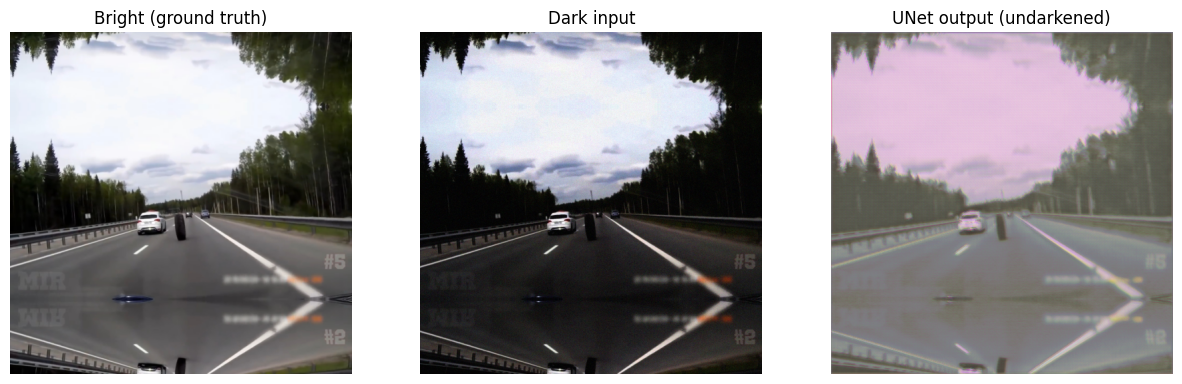

Example: /content/RoadAnomaly_jpg/frames/lost_tires08.jpg


In [4]:
#@title Train UNet and visualize an example

def train_unet(cfg):
    train_loader, val_loader, bright_paths, _ = create_dataloaders(cfg)
    if train_loader is None:
        print("Training aborted: dataloaders not ready.")
        return None

    device = cfg.device
    model = UNet(in_ch=3, out_ch=3, base_ch=32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    criterion = nn.L1Loss()

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(cfg.num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [train]"):
            dark = batch["dark"].to(device)
            bright = batch["bright"].to(device)

            optimizer.zero_grad()
            pred = model(dark)
            loss = criterion(pred, bright)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * dark.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: train L1 = {train_loss:.4f}")

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [val]"):
                dark = batch["dark"].to(device)
                bright = batch["bright"].to(device)
                pred = model(dark)
                loss = criterion(pred, bright)
                val_running += loss.item() * dark.size(0)
        val_loss = val_running / len(val_loader.dataset)
        print(f"Epoch {epoch+1}: val L1 = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict().copy()
            print(f"🌟 New best model with val L1 = {best_val_loss:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    ckpt_dir = os.path.join(cfg.dataset_root, "checkpoints")
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, "unet_dark_to_bright.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved best model to {ckpt_path}")
    return model

def visualize_example(model, cfg):
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        print("Dataset not ready, cannot visualize.")
        return

    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        return

    import random as _random
    bright_path = _random.choice(bright_paths)
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    dark_path = os.path.join(dark_dir, os.path.basename(bright_path))

    bright = load_and_preprocess(bright_path, cfg.image_size)
    dark = load_and_preprocess(dark_path, cfg.image_size)

    dark_t = torch.from_numpy(dark).permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    model.eval()
    with torch.no_grad():
        pred_t = model(dark_t)
    pred = pred_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(bright)
    axes[0].set_title("Bright (ground truth)")
    axes[0].axis("off")
    axes[1].imshow(dark)
    axes[1].set_title("Dark input")
    axes[1].axis("off")
    axes[2].imshow(pred)
    axes[2].set_title("UNet output (undarkened)")
    axes[2].axis("off")
    plt.show()
    print("Example:", bright_path)

# ---- Run training and show result ----

model = train_unet(cfg)
if model is not None:
    visualize_example(model, cfg)


✅ Found 60 bright images in /content/RoadAnomaly_jpg/frames
🔁 Loaded split from /content/RoadAnomaly_jpg/split_indices.npz (train=48, val=12)
✅ Dark images ready in /content/RoadAnomaly_jpg/frames_dark. Newly created: 0
Train batches: 12, Val batches: 3


Epoch 1/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 1: train L1 = 0.1666


Epoch 1/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Epoch 1: val L1 = 0.2171
🌟 New best model with val L1 = 0.2171


Epoch 2/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch 2: train L1 = 0.1217


Epoch 2/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Epoch 2: val L1 = 0.2016
🌟 New best model with val L1 = 0.2016


Epoch 3/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 3: train L1 = 0.1034


Epoch 3/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


Epoch 3: val L1 = 0.1547
🌟 New best model with val L1 = 0.1547


Epoch 4/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch 4: train L1 = 0.0928


Epoch 4/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Epoch 4: val L1 = 0.1183
🌟 New best model with val L1 = 0.1183


Epoch 5/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Epoch 5: train L1 = 0.0911


Epoch 5/30 [val]: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 5: val L1 = 0.0987
🌟 New best model with val L1 = 0.0987


Epoch 6/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch 6: train L1 = 0.0833


Epoch 6/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


Epoch 6: val L1 = 0.0839
🌟 New best model with val L1 = 0.0839


Epoch 7/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch 7: train L1 = 0.0810


Epoch 7/30 [val]: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 7: val L1 = 0.0899


Epoch 8/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


Epoch 8: train L1 = 0.0773


Epoch 8/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


Epoch 8: val L1 = 0.0799
🌟 New best model with val L1 = 0.0799


Epoch 9/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Epoch 9: train L1 = 0.0777


Epoch 9/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 9: val L1 = 0.0901


Epoch 10/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch 10: train L1 = 0.0797


Epoch 10/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Epoch 10: val L1 = 0.0759
🌟 New best model with val L1 = 0.0759


Epoch 11/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch 11: train L1 = 0.0783


Epoch 11/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


Epoch 11: val L1 = 0.0845


Epoch 12/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch 12: train L1 = 0.0748


Epoch 12/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


Epoch 12: val L1 = 0.0822


Epoch 13/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


Epoch 13: train L1 = 0.0740


Epoch 13/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Epoch 13: val L1 = 0.0809


Epoch 14/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


Epoch 14: train L1 = 0.0726


Epoch 14/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 14: val L1 = 0.0724
🌟 New best model with val L1 = 0.0724


Epoch 15/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch 15: train L1 = 0.0725


Epoch 15/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Epoch 15: val L1 = 0.0800


Epoch 16/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch 16: train L1 = 0.0690


Epoch 16/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 16: val L1 = 0.0707
🌟 New best model with val L1 = 0.0707


Epoch 17/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Epoch 17: train L1 = 0.0709


Epoch 17/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 17: val L1 = 0.0787


Epoch 18/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 18: train L1 = 0.0692


Epoch 18/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Epoch 18: val L1 = 0.0753


Epoch 19/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 19: train L1 = 0.0733


Epoch 19/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 19: val L1 = 0.0695
🌟 New best model with val L1 = 0.0695


Epoch 20/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch 20: train L1 = 0.0680


Epoch 20/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 20: val L1 = 0.0842


Epoch 21/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 21: train L1 = 0.0681


Epoch 21/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 21: val L1 = 0.0779


Epoch 22/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch 22: train L1 = 0.0687


Epoch 22/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 22: val L1 = 0.0697


Epoch 23/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch 23: train L1 = 0.0629


Epoch 23/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 23: val L1 = 0.0673
🌟 New best model with val L1 = 0.0673


Epoch 24/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch 24: train L1 = 0.0655


Epoch 24/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 24: val L1 = 0.0680


Epoch 25/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 25: train L1 = 0.0671


Epoch 25/30 [val]: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 25: val L1 = 0.0744


Epoch 26/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


Epoch 26: train L1 = 0.0673


Epoch 26/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Epoch 26: val L1 = 0.0663
🌟 New best model with val L1 = 0.0663


Epoch 27/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 27: train L1 = 0.0590


Epoch 27/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 27: val L1 = 0.0819


Epoch 28/30 [train]: 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch 28: train L1 = 0.0589


Epoch 28/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 28: val L1 = 0.0661
🌟 New best model with val L1 = 0.0661


Epoch 29/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 29: train L1 = 0.0658


Epoch 29/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 29: val L1 = 0.0659
🌟 New best model with val L1 = 0.0659


Epoch 30/30 [train]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch 30: train L1 = 0.0663


Epoch 30/30 [val]: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 30: val L1 = 0.0808
💾 Saved best model to /content/RoadAnomaly_jpg/checkpoints/unet_dark_to_bright.pth
✅ Found 60 bright images in /content/RoadAnomaly_jpg/frames


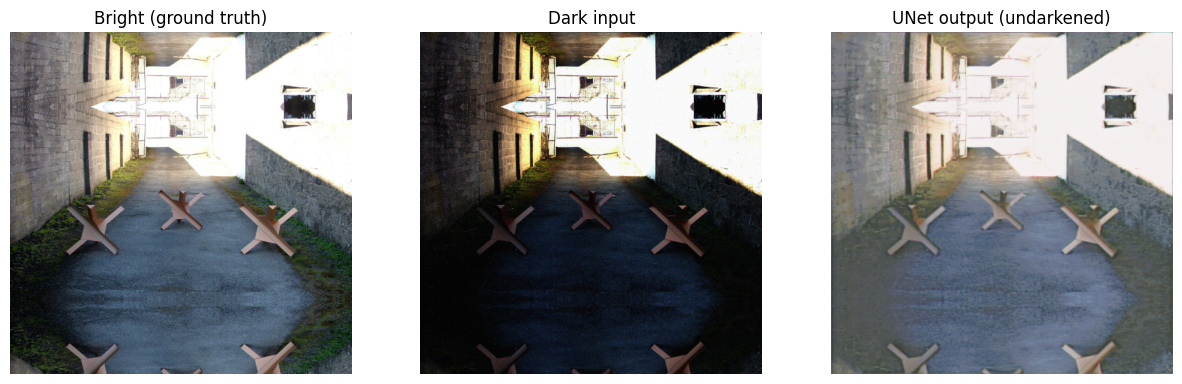

Example: /content/RoadAnomaly_jpg/frames/obstacles06_cardboard_czech_hedgehog.jpg


In [12]:
cfg.num_epochs = 30;
model = train_unet(cfg)
if model is not None:
    visualize_example(model, cfg)


In [ ]:
#@title Clone DeepLabV3+ Cityscapes repo and download weights
import os
from pathlib import Path

REPO_ROOT = Path("/content/DeepLabV3Plus-Pytorch")

if not REPO_ROOT.exists():
    # Clone the repository only once
    !git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git /content/DeepLabV3Plus-Pytorch
else:
    print("Repo already exists at", REPO_ROOT)

# Install requirements (PyTorch is already available in Colab)
%cd /content/DeepLabV3Plus-Pytorch
!pip install -q -r requirements.txt

# Ensure checkpoint directory and download Cityscapes model if missing
from pathlib import Path as _Path
CKPT_DIR = _Path("checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CKPT_DIR / "best_deeplabv3plus_mobilenet_cityscapes_os16.pth"

# Official Cityscapes checkpoint URL from the DeepLabV3Plus-Pytorch repo
CKPT_URL = "https://www.dropbox.com/scl/fi/jo4nhw3h6lcg8t2ckarae/best_deeplabv3plus_mobilenet_cityscapes_os16.pth?rlkey=7qnzapkshyofrgfa1ls7vot6j&dl=1"

import subprocess as _subprocess
if not CKPT_PATH.exists():
    print("Downloading Cityscapes pretrained checkpoint...")
    _subprocess.run(["wget", "-q", "-O", str(CKPT_PATH), CKPT_URL], check=True)
    print("Download complete:", CKPT_PATH)
else:
    print("Checkpoint already exists:", CKPT_PATH)

# Go back to default working directory
%cd /content


In [ ]:
#@title Cityscapes anomaly model + utilities (DeepLabV3+ on UNet output)
import os
import sys
from pathlib import Path

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Add DeepLabV3Plus repo to path
REPO_ROOT = Path("/content/DeepLabV3Plus-Pytorch")
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

import network  # comes from the DeepLabV3Plus-Pytorch repo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 19
MODEL_NAME = "deeplabv3plus_mobilenet"
CKPT_PATH = REPO_ROOT / "checkpoints" / "best_deeplabv3plus_mobilenet_cityscapes_os16.pth"

def load_cityscapes_model():
    """Load pretrained DeepLabV3+ on Cityscapes."""
    print("Loading Cityscapes model:", MODEL_NAME)
    model = network.modeling.__dict__[MODEL_NAME](
        num_classes=NUM_CLASSES,
        output_stride=16,
    )
    ckpt = torch.load(str(CKPT_PATH), map_location=DEVICE)
    state = ckpt.get("model_state", ckpt)
    model.load_state_dict(state)
    model.eval()
    model.to(DEVICE)
    print("Model loaded on", DEVICE)
    return model

def preprocess_for_deeplab(img_bgr, input_size=512):
    """Prepare BGR uint8 image for DeepLabV3+ forward pass."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    img_resized = cv2.resize(img_rgb, (input_size, input_size), interpolation=cv2.INTER_LINEAR)
    img_resized = img_resized.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_norm = (img_resized - mean) / std

    tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0)  # [1,3,H,W]
    return tensor.to(DEVICE), (orig_h, orig_w)

def infer_anomaly_outline(model, img_bgr, conf_thresh=0.6):
    """
    Use DeepLabV3+ to get per-pixel max probability; treat low-confidence pixels
    as anomalies and return (mask, outlined_img).
    """
    with torch.no_grad():
        inp, (H, W) = preprocess_for_deeplab(img_bgr)
        outputs = model(inp)              # [1, C, h, w]
        logits = outputs[0]               # [C, h, w]
        logits = F.interpolate(
            logits.unsqueeze(0), size=(H, W),
            mode="bilinear", align_corners=False
        )[0]                              # [C, H, W]
        probs = torch.softmax(logits, dim=0)
        max_probs, _ = probs.max(dim=0)
        max_probs_np = max_probs.cpu().numpy()

    anomaly_mask = (max_probs_np < conf_thresh).astype(np.uint8)

    kernel = np.ones((5, 5), np.uint8)
    anomaly_mask = cv2.morphologyEx(anomaly_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    anomaly_mask = cv2.morphologyEx(anomaly_mask, cv2.MORPH_DILATE, kernel, iterations=1)

    anomaly_mask_vis = (anomaly_mask * 255).astype(np.uint8)

    contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = img_bgr.copy()
    cv2.drawContours(outlined, contours, -1, (0, 0, 255), 2)  # red in BGR
    outlined = cv2.addWeighted(outlined, 0.8, img_bgr, 0.2, 0)

    return anomaly_mask_vis, outlined

def visualize_example_with_city_anomaly(unet_model, city_model, cfg, conf_thresh=0.6):
    """
    Pick a random RoadAnomaly frame, run:
      dark -> UNet -> brightened prediction
      then Cityscapes DeepLabV3+ to find low-confidence (anomalous) regions
      on the UNet prediction and plot everything side-by-side.
    """
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        print("Dataset not ready, cannot visualize.")
        return

    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        print("No bright images found.")
        return

    import random as _random
    bright_path = _random.choice(bright_paths)
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    dark_path = os.path.join(dark_dir, os.path.basename(bright_path))

    bright = load_and_preprocess(bright_path, cfg.image_size)
    dark = load_and_preprocess(dark_path, cfg.image_size)

    # UNet prediction (dark -> bright)
    dark_t = torch.from_numpy(dark).permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    with torch.no_grad():
        pred_t = unet_model(dark_t)
    pred = pred_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0)

    # Convert UNet output to BGR uint8 for DeepLab
    pred_rgb_uint8 = (pred * 255.0).astype(np.uint8)
    pred_bgr_uint8 = cv2.cvtColor(pred_rgb_uint8, cv2.COLOR_RGB2BGR)

    anomaly_mask, outlined_bgr = infer_anomaly_outline(city_model, pred_bgr_uint8,
                                                       conf_thresh=conf_thresh)
    outlined_rgb = cv2.cvtColor(outlined_bgr, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(bright)
    axes[0].set_title("Bright (ground truth)")
    axes[0].axis("off")

    axes[1].imshow(dark)
    axes[1].set_title("Dark input")
    axes[1].axis("off")

    axes[2].imshow(pred)
    axes[2].set_title("UNet output")
    axes[2].axis("off")

    axes[3].imshow(anomaly_mask, cmap="gray")
    axes[3].set_title("Anomaly mask")
    axes[3].axis("off")

    axes[4].imshow(outlined_rgb)
    axes[4].set_title("UNet + anomaly outlines")
    axes[4].axis("off")

    plt.show()
    print("Example frame:", bright_path)


In [ ]:
#@title Run Cityscapes anomaly detection on a UNet example
if "model" not in globals():
    print("UNet model variable 'model' not found. Train it first (run the training cell).")
else:
    city_model = load_cityscapes_model()
    visualize_example_with_city_anomaly(model, city_model, cfg)
